## 1. Importing Libraries


In [6]:
import pandas as pd 
import tensorflow as tf

from keras.layers import TextVectorization
import time
from sklearn.preprocessing import LabelEncoder
import keras
import re
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from tensorflow.keras.models import load_model

## 2. Loading and Exploring the Data

In [7]:
test = pd.read_csv('data/cyberbullying_test.csv')
train = pd.read_csv('data/cyberbullying_train.csv')
val = pd.read_csv('data/cyberbullying_val.csv')

In [8]:
test['target'] = 'test'
train['target'] = 'train'
val['target'] = 'val'

In [9]:
df = pd.concat([test,train,val],axis=0).reset_index(drop=True)

## 3. Data Cleaning and Preparation

In [10]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's','cuz'])

def lower(text):
    return text.lower()

def remove_twitter(text):
    return re.sub(TEXT_CLEANING_RE, ' ', text)

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def clean_text(text):
    text = lower(text)
    text = remove_twitter(text)
    text = remove_stopwords(text)
    text = text.strip()
    return text

In [11]:
df['tweet_text']=df['tweet_text'].apply(clean_text)

df = df[df['tweet_text'] != '']

In [12]:
lblencoder = LabelEncoder()
df['cyberbullying_type'] = lblencoder.fit_transform(df['cyberbullying_type'])

## 4. Scaling or Normalizing Data


In [13]:
total_text = df['tweet_text'].values
target = df['cyberbullying_type'].values

In [14]:
train = df[df['target'] == 'train'].drop(columns='target').reset_index(drop=True)
test = df[df['target'] == 'test'].drop(columns='target').reset_index(drop=True)
val = df[df['target'] == 'val'].drop(columns='target').reset_index(drop=True)

In [15]:
x_train = train['tweet_text'].values
y_train = train['cyberbullying_type'].values

x_test = test['tweet_text'].values
y_test = test['cyberbullying_type'].values

x_val = val['tweet_text'].values
y_val = val['cyberbullying_type'].values

In [16]:
# Crear datasets de TensorFlow
raw_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
raw_test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
raw_val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [17]:
vocab_size = 20000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='tf-idf'
)

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x) ########

start = time.time()
vectorize_layer.adapt(text_ds)
print(f'Time for adapt is {time.time()-start:.4f}')

Time for adapt is 374.4449


In [18]:
batch_size = 32
raw_train_ds = raw_train_ds.shuffle(20000).batch(batch_size)
raw_val_ds = raw_val_ds.batch(batch_size)
raw_test_ds = raw_test_ds.batch(batch_size)

In [19]:
def preprocess(x,y):
    x = vectorize_layer(x)
    y = tf.one_hot(y, depth=6)
    return x,y

train_ds = raw_train_ds.map(lambda x,y: preprocess(x,y))
test_ds = raw_test_ds.map(lambda x,y: preprocess(x,y))
val_ds = raw_val_ds.map(lambda x,y: preprocess(x,y))

## 5. Model Building and Training


In [20]:
@keras.saving.register_keras_serializable()
class Linear(keras.layers.Layer):
    def __init__(self, num_outputs, activation=None):
        super().__init__()
        self.num_outputs = num_outputs
        self.activation = keras.activations.get(activation)
        self.batch_norm = keras.layers.BatchNormalization()


    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.w = self.add_weight(
            shape=[input_dim, self.num_outputs], 
            name="kernel", 
            regularizer=keras.regularizers.l2(0.001)
        )
        self.b = self.add_weight(shape=[self.num_outputs], name="bias")


    def call(self, inputs, training=False):
        x = tf.matmul(inputs, self.w) + self.b
        x = self.batch_norm(x, training=training)
        return self.activation(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_outputs": self.num_outputs,
            "activation": keras.activations.serialize(self.activation)
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [21]:
@keras.saving.register_keras_serializable()
class Model(keras.Model):
    def __init__(self, activation, dropout_rate=0.3, **kwargs): ##################
        super().__init__(**kwargs)
        self.l1 = Linear(64, activation) 
        self.batch_norm1 = keras.layers.BatchNormalization()  
        self.dropout1 = keras.layers.Dropout(dropout_rate)  
        self.l2 = Linear(6, activation='softmax') 

    def call(self, x, training=False):
        x = self.l1(x)
        x = self.batch_norm1(x, training=training) 
        x = self.dropout1(x, training=training) 
        return self.l2(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "activation": keras.activations.serialize(self.l1.activation),
            "dropout_rate": self.dropout1.rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


### relu

In [22]:
model = Model('relu')

In [23]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=["accuracy"]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="best_model.weights.h5",
    save_weights_only=True,
    save_best_only=True, 
    monitor="val_loss", 
    mode="min",          
    verbose=1
)

# Entrenar el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint_callback],
)

Epoch 1/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7330 - loss: 0.9392
Epoch 1: val_loss improved from inf to 0.66672, saving model to best_model.weights.h5
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 48s 43ms/step - accuracy: 0.7331 - loss: 0.9390 - val_accuracy: 0.8314 - val_loss: 0.6667
Epoch 2/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8675 - loss: 0.6073
Epoch 2: val_loss improved from 0.66672 to 0.63583, saving model to best_model.weights.h5
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.8675 - loss: 0.6073 - val_accuracy: 0.8321 - val_loss: 0.6358
Epoch 3/10
1036/1037 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8783 - loss: 0.5624
Epoch 3: val_loss did not improve from 0.63583
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.8783 - loss: 0.5624 - val_accuracy: 0.8304 - val_loss: 0.6480
Epoch 4/10
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8799 - loss: 0.5564
Epoch 4: val_loss did not improve from 0.63583
1037/1037 ━

In [24]:
# Guardar el modelo completo en un archivo
model.save("model.keras")
model.save_weights("best_model.weights.h5") 

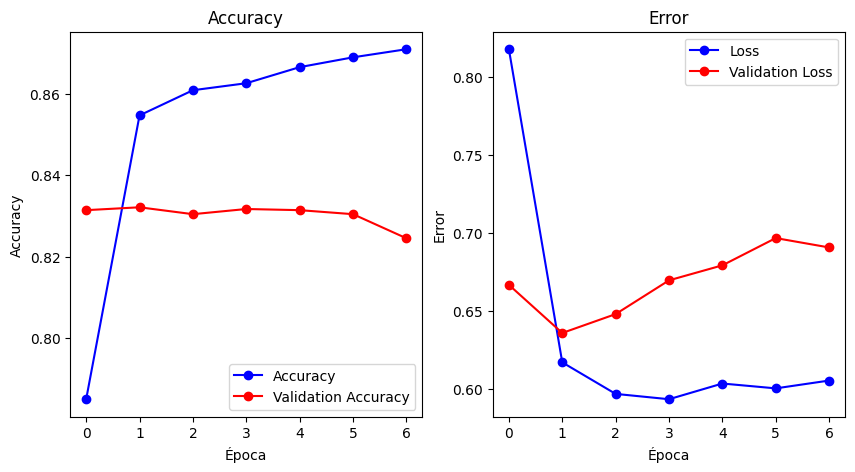

In [25]:
# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot de accuracy en el primer subplot
ax1.plot(history.history['accuracy'], 'bo-', label='Accuracy')
ax1.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Época')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot de error en el segundo subplot
ax2.plot(history.history['loss'], 'bo-', label='Loss')
ax2.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
ax2.set_title('Error')
ax2.set_xlabel('Época')
ax2.set_ylabel('Error')
ax2.legend()

# Mostrar figura
plt.show()

## 6. Model Evaluation

In [26]:
loaded_model = Model(activation='relu') 
loaded_model = load_model("model.keras") 

loaded_model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

test_loss, test_accuracy = loaded_model.evaluate(test_ds)
print(f"Loss en test: {test_loss}, Accuracy en test: {test_accuracy}")


223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8283 - loss: 0.6515
Loss en test: 0.6483999490737915, Accuracy en test: 0.8305203914642334


In [27]:
# Obtener las predicciones
predictions = loaded_model.predict(test_ds)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


### Matriz de Confusión

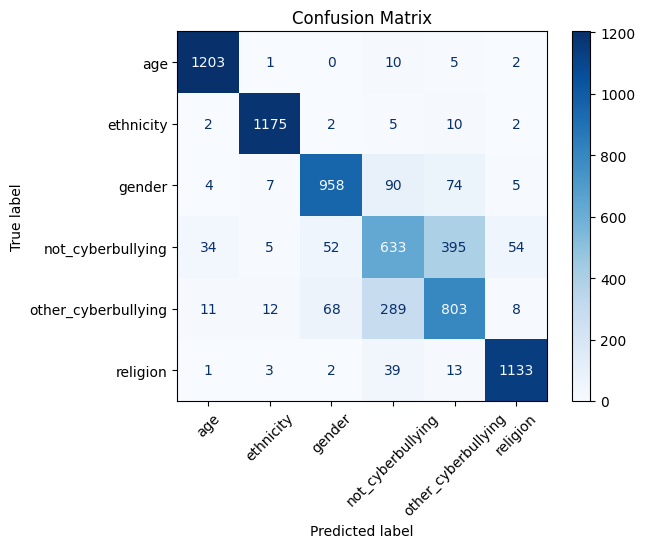

In [35]:
cm = confusion_matrix(true_classes, predicted_classes)

# Definir las etiquetas personalizadas
labels = lblencoder.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

### Clasiffication Report

In [31]:
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1221
           1       0.98      0.98      0.98      1196
           2       0.89      0.84      0.86      1138
           3       0.59      0.54      0.57      1173
           4       0.62      0.67      0.64      1191
           5       0.94      0.95      0.95      1191

    accuracy                           0.83      7110
   macro avg       0.83      0.83      0.83      7110
weighted avg       0.83      0.83      0.83      7110



In [30]:
accuracy_score(test['cyberbullying_type'],predicted_classes)

0.8305203938115331

## Step by Step

### Loading and exploring data



* Cargar datos: Se importan los conjuntos de datos desde archivos CSV: test, train y val.
* Etiquetar conjuntos: Se añade una columna target para identificar cada conjunto: 'test', 'train' y 'val'.
* Concatenar DataFrames: Se combinan todos los DataFrames en uno solo (df), restableciendo el índice.


### Data Cleaning and Preparation

Definir expresiones y listas:
1. Se establece una expresión regular (TEXT_CLEANING_RE) para limpiar textos de Twitter, eliminando menciones, enlaces y caracteres no alfanuméricos.
2. Se actualizan las palabras vacías (stopwords) con términos específicos relacionados con Twitter.

Funciones de limpieza de texto:

3. lower(text): Convierte el texto a minúsculas.
4. remove_twitter(text): Aplica la expresión regular para eliminar menciones y enlaces.
5. remove_stopwords(text): Elimina las palabras vacías definidas de cada texto.
6. clean_text(text): Combina las funciones anteriores y limpia el texto, eliminando espacios al inicio y al final.

Aplicar limpieza:

7. Se aplica la función clean_text a la columna tweet_text del DataFrame df.

Filtrar textos vacíos:

8. Se eliminan las filas donde tweet_text está vacío.

Codificación de etiquetas:

9. Se utiliza LabelEncoder para transformar la columna cyberbullying_type en números, facilitando el uso en modelos de machine learning.

### Scaling or Normalization Data

Definir variables:

1. total_text: Se extraen todos los textos de tweet_text.
2. target: Se extraen las etiquetas de cyberbullying_type.

Crear conjuntos de entrenamiento, prueba y validación:

3. Se filtran los datos según el valor de la columna target (train, test, val).
4. Se eliminan las columnas innecesarias y se restablece el índice.

Separar características y etiquetas:

5. Se obtienen los textos y etiquetas para los conjuntos de entrenamiento, prueba y validación.

Crear datasets de TensorFlow:

6. Se crean datasets utilizando tf.data.Dataset.from_tensor_slices para los conjuntos total, de entrenamiento, prueba y validación.

Definir y adaptar la capa de vectorización:

7. Se define una capa TextVectorization para convertir texto en vectores, especificando un tamaño de vocabulario (vocab_size).
8. Se adapta la capa de vectorización al conjunto de textos del entrenamiento.

Preparar los datasets para el entrenamiento:

9. Se barajan y agrupan los datasets de entrenamiento, validación y prueba en lotes de tamaño 32.

Preprocesar los datos:

10. Se define la función preprocess para vectorizar el texto y aplicar codificación one-hot a las etiquetas.
11. Se aplican transformaciones de preprocesamiento a los datasets de entrenamiento, validación y prueba.

### Model building and Training

Definir la capa Linear:

1. Clase que hereda de keras.layers.Layer y representa una capa lineal personalizada.
2. Inicialización: Recibe el número de salidas y una función de activación opcional. Incluye normalización por lotes.
3. Construcción: Define los pesos y sesgos, aplicando una regularización L2.
4. Llamada: Realiza la multiplicación de matrices y aplica la activación y normalización.
5. Configuración: Métodos para obtener y cargar la configuración de la capa.


Definir el modelo:

6. Clase que hereda de keras.Model, que utiliza la capa Linear.
7. Inicialización: Define dos capas lineales, una normalización por lotes y una capa de abandono (dropout).
8. Llamada: Pasa los datos a través de las capas definidas.
9. Configuración: Métodos para obtener y cargar la configuración del modelo.

Compilación del modelo:

10. Se compila el modelo con la pérdida de entropía cruzada categórica, el optimizador Adam y la métrica de precisión.

Definición de callbacks:

11. EarlyStopping: Detiene el entrenamiento si no hay mejora en la pérdida de validación durante 5 épocas.
12. ModelCheckpoint: Guarda los mejores pesos del modelo basándose en la pérdida de validación.

Entrenamiento del modelo:

13. Se entrena el modelo utilizando el conjunto de entrenamiento y validación durante 10 épocas, aplicando los callbacks definidos.

Guardar el modelo:

14. Se guarda el modelo completo y sus pesos en archivos específicos.

Visualización de resultados:

15. Se crean subgráficos para mostrar la precisión y la pérdida durante el entrenamiento.
16. Se grafican la precisión y la pérdida de entrenamiento y validación en sus respectivos subgráficos.

### Model Evaluation

Cargar el modelo:

1. Se inicializa una instancia del modelo con la activación 'relu'.
2. Se carga el modelo previamente guardado desde el archivo "model.keras".

Compilar el modelo con:

3. Pérdida de entropía cruzada categórica.
4. Optimizador Adam con una tasa de aprendizaje de 0.01.
5. Métrica de precisión.

Evaluar el modelo:

6. Se evalúa el rendimiento del modelo en el conjunto de prueba (test_ds), obteniendo la pérdida y la precisión.
7. Se imprimen los resultados de la evaluación.

Obtener predicciones:

8. Se generan predicciones sobre el conjunto de prueba usando el modelo cargado.
9. Se convierten las predicciones a clases predichas (usando argmax).

Visualizar la matriz de confusión

Generar un informe de clasificación

# Conclusion

Al inicio de este trabajo, enfrenté algunas complejidades debido a mi falta de experiencia con TensorFlow, ya que hasta ahora he estado más enfocado en mejorar en scikit-learn. Aprendí que al intentar ejecutar el modelo solo con los pesos guardados (tuve ese problema todo el fin de semana), no se obtiene el rendimiento esperado, dado que estos pesos están personalizados para una arquitectura específica. Por lo tanto, es crucial cargar el modelo completo en lugar de solo los pesos.

Además, el diseño del modelo incluye capas como la normalización por lotes y la capa de abandono (dropout), lo que debería ayudar a prevenir el sobreajuste. Quizá podría obtener mejores resultados a los ya obtenidos (0.8305203938115331), pero tendría que empezar a probar con más parámetros y eso es gasto computacional ya que cada ejecución demora aprox 15 min